In [1]:
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score # Please note that this is the only sklearn function that can be utilized.

# Load data

In [2]:
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(800, 7)
(800,)
(800, 7)
(800,)
(800, 7)
(800,)


# Model Implementation

In [4]:
def gini(sequence):
    labels, counts = np.unique(sequence, return_counts=True)
    probs = counts/ float(np.shape(sequence)[0])
    gini = 1- np.sum(probs * probs)
    return gini    


def entropy(sequence):
    labels, counts = np.unique(sequence, return_counts=True)
    probs = counts/ float(np.shape(sequence)[0])
    entropy = - np.sum(probs * np.log2(probs))
    return entropy    

In [5]:
class Tree():
    """
        You can add/change any variables/methods to meet your need.
    """   
    def __init__(self, true_branch=None, false_branch=None, feature_index=0, threshold=0, depth=0):    
        self.left_child = false_branch        
        self.right_child = true_branch
        self.feature_index = feature_index
        self.threshold = threshold
        self.depth = depth
        self.is_leaf = 0
        self.predict_feature = 0
        self.gain = 0
        
    def set_node(self, feature_index=None, threshold=None, depth= 0, gain=0):
        self.left_child = Tree()
        self.right_child = Tree()
        self.feature_index = feature_index
        self.threshold = threshold
        self.depth = depth
        self.gain = gain

    def set_leaf(self, predict_feature, depth= 0):
        self.predict_feature = predict_feature
        self.is_leaf = 1
        
    def get_branch(self):
      return self.right_child, self.left_child

In [6]:
class DecisionTree():
    def __init__(self, criterion='gini', max_depth=None, max_features=None):       
        """
            You can add/change any variables/methods to meet your need.
        """
        self.criterion = criterion
        self.importance = {}
        self.tree = Tree()
        self.max_features = max_features
        
        if max_depth is None:
            self.max_depth = 1e9
        else:
            self.max_depth = max_depth
            
    def criterion_calculation(self,sequence):
        if np.shape(sequence)[0] == 0:
            return 0
        if self.criterion == 'gini':
            return gini(sequence)
        if self.criterion == 'entropy':
            return entropy(sequence)

    def fit(self, X, y, sample_weight=None):
        if self.max_features == None:
            self.max_features = np.shape(X)[1]
        self.build_tree(X, y, 0, self.tree)
        self.countImportance()

    def build_tree(self, X, y, depth, curr_node):
        if depth < self.max_depth:
            critierion_gain, condition, threshold, True_X, True_y, False_X, False_y = self.find_best_split(X,y)
            if critierion_gain == 0:
                values, counts = np.unique(y, return_counts=True)
                most_class = values[np.argmax(counts)]
                curr_node.set_leaf(predict_feature = most_class, depth= depth)             
            else:
                curr_node.set_node(feature_index= condition, threshold= threshold, depth= depth, gain= critierion_gain)
                true_branch, false_branch = curr_node.get_branch()
                self.build_tree(True_X, True_y, depth+1, true_branch)
                self.build_tree(False_X, False_y, depth+1, false_branch)
        
        if depth == self.max_depth:
            values, counts = np.unique(y, return_counts=True)
            most_class = values[np.argmax(counts)]
            curr_node.set_leaf(predict_feature = most_class, depth= depth)

    def find_best_split(self,X,y):
        total_critierion = self.criterion_calculation(y)
        min_splitted_critierion = float('inf')
        best_threshold = 0
        best_condition = 0
        dataset_size = np.shape(X)[0]
        num_feature = np.shape(X)[1]
        choose_feature = np.random.choice(num_feature, self.max_features, replace=False)
        for col in choose_feature:
            col_value = np.unique(X[:,col])
            if(np.shape(col_value)[0] == 1):
                min_splitted_critierion = total_critierion
                break
            
            col_mean_value = ((col_value + np.roll(col_value, 1))/2)[1:]
            for threshold in col_mean_value:
                TF_table = np.where(X[:,col]>=threshold, True, False)
                splitted_critierion = ((dataset_size - TF_table.sum()) * self.criterion_calculation(y[np.invert(TF_table)]) + TF_table.sum()*self.criterion_calculation(y[TF_table]))/dataset_size
          
                if splitted_critierion < min_splitted_critierion:
                    min_splitted_critierion = splitted_critierion
                    best_condition = col
                    best_threshold = threshold
            
        best_TF_table = np.where(X[:,best_condition]>=best_threshold, True, False)     
        return total_critierion - min_splitted_critierion, best_condition, best_threshold, X[best_TF_table], y[best_TF_table], X[np.invert(best_TF_table)], y[np.invert(best_TF_table)]
    
    def predict(self, X):
        num_data = np.shape(X)[0]
        prediction = np.zeros(num_data)
        for i in range(num_data):
            prediction[i] = self.find_the_leaf(self.tree, X[i])
        return prediction
    
    def find_the_leaf(self, curr_node, X_row):
        if curr_node.is_leaf == 1:
            return curr_node.predict_feature
        else:
            child_node = None
            if X_row[curr_node.feature_index]>= curr_node.threshold:
                child_node = curr_node.right_child
            else:
                child_node = curr_node.left_child
            return self.find_the_leaf(child_node, X_row)
        
    def countImportance(self):
        self.traverse_tree(self.tree, mode="calculate_importance")

    def traverse_tree(self,curr_node, mode="print", str="root"):
        if(curr_node.is_leaf == 0):
            if(mode == "print"):
                self.print_node_info(curr_node, str)
                self.traverse_tree(curr_node.left_child,mode,str+"->left")
                self.traverse_tree(curr_node.right_child,mode,str+"->right")
            
            if(mode == "calculate_importance"):
                self.update_importance(curr_node)
                self.traverse_tree(curr_node.left_child,mode)
                self.traverse_tree(curr_node.right_child,mode)            

        else:
            if(mode == "print"):
                self.print_leaf_info(curr_node, str)
            
    def print_node_info(self,curr_node, str):
        print("str : ",str)
        print("curr_node.feature_index : ",curr_node.feature_index)
        print("curr_node.threshold : ",curr_node.threshold)
        print("curr_node.depth : ",curr_node.depth)
        print("curr_node.is_leaf : ",curr_node.is_leaf)
        print("curr_node.gain : ",curr_node.gain)
        print("-------------------------")
        
    def print_leaf_info(self,curr_node, str):
        print("str : ",str)
        print("curr_node.is_leaf : ",curr_node.is_leaf)
        print("curr_node.predict_feature : ",curr_node.predict_feature)
        print("-------------------------")
    
    def update_importance(self, curr_node):
        feature_index = curr_node.feature_index
        if feature_index not in self.importance:
            self.importance[feature_index] = 1
        else:
            self.importance[feature_index] += 1
            
    def print_importance(self):
        #for key in self.importance:
        #    print(key," : ",self.importance[key])
        print(self.importance)
        
    def draw_importance(self, labelList, title):
        feature_num = len(self.importance)
        np_importance = np.zeros(feature_num)
        for i in range(feature_num):
            np_importance[i] = self.importance[i]
        index = np.argsort(np_importance)
        sort_labellist = []
        for i in range(feature_num):
            sort_labellist.append(labelList[index[i]])
        plt.title(title)
        plt.barh(sort_labellist, np_importance[index])
        plt.show()

In [7]:
class RandomForest():
    """
        You can add/change any variables/methods to meet your need.
    """
    def __init__(self, n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None):
        
        self.n_estimators = n_estimators
        self.boostrap = boostrap
        self.criterion = criterion
        self.forest = []
        self.max_depth = max_depth
        if max_features==None:
            self.max_features = None
        else:
            self.max_features = np.int64(max_features)
        
    def fit(self, X, y, feature_random = False): 
        dataset_size = np.shape(X)[0]        
            
        for i in range(self.n_estimators):
            #Initialize tree       
            tree_i = DecisionTree(criterion=self.criterion, max_features= self.max_features, max_depth=self.max_depth)
            #Train the tree
            if self.boostrap == True:
                boostrapping_index = np.random.choice(dataset_size, dataset_size, replace=True)
                train_X = X[boostrapping_index]
                train_y = y[boostrapping_index]
            else:
                train_X = X
                train_y = y           
            tree_i.fit(train_X[:], train_y, sample_weight=None)
            #Append tree into forest
            self.forest.append(tree_i)

    def predict(self, X):
        # majority vote
        num_data = np.shape(X)[0]
        total_prediction = np.zeros((len(self.forest), num_data))
        prediction = np.zeros((num_data))
        
        for i, tree in enumerate(self.forest):
            total_prediction[i] = tree.predict(X)
        total_prediction = np.transpose(total_prediction, (1, 0))
        
        for i in range(num_data):
            values, counts = np.unique(total_prediction[i], return_counts=True)
            prediction[i] = values[np.argmax(counts)]
            
        return prediction        

# Questions for Decision Tree

In [8]:
# For Q1
ex1 = np.array(["+", "+", "+", "+", "+", "-"])
ex2 = np.array(["+", "+", "+", "-", "-", "-"])
ex3 = np.array(["+" ,"-", "-", "-", "-", "-"])

print(f"{ex1}: entropy = {entropy(ex1)}\n{ex2}: entropy = {entropy(ex2)}\n{ex3}: entropy = {entropy(ex3)}\n")
print(f"{ex1}: gini index = {gini(ex1)}\n{ex2}: gini index = {gini(ex2)}\n{ex3}: gini index = {gini(ex3)}\n")

['+' '+' '+' '+' '+' '-']: entropy = 0.6500224216483541
['+' '+' '+' '-' '-' '-']: entropy = 1.0
['+' '-' '-' '-' '-' '-']: entropy = 0.6500224216483541

['+' '+' '+' '+' '+' '-']: gini index = 0.2777777777777777
['+' '+' '+' '-' '-' '-']: gini index = 0.5
['+' '-' '-' '-' '-' '-']: gini index = 0.2777777777777777



In [9]:
# For Q2-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0) # You may adjust the seed number in all the cells

dt_depth3 = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_depth3.fit(X_train, y_train, sample_weight=None)
acc = accuracy_score(y_val, dt_depth3.predict(X_val))

print("Q2-1 max_depth=3: ", acc)

Q2-1 max_depth=3:  0.73125


In [10]:
""" Do Not Modify Below """

from sklearn.tree import DecisionTreeClassifier as SK_DecisionTreeClassifier

sk_dt = SK_DecisionTreeClassifier(criterion='gini', max_depth=3)
sk_dt.fit(X_train, y_train)
sk_acc = accuracy_score(y_val, sk_dt.predict(X_val))

assert round(acc, 3) == round(sk_acc, 3), "Because the Decision Tree without any trick has a fixed answer, your accuracy should be the same as sklearn, otherwise your implementation might have some problems"

In [11]:
# For Q2-2, validation accuracy should be higher than or equal to 0.85

np.random.seed(0)
dt_depth10 = DecisionTree(criterion='gini', max_features=None, max_depth=10)
dt_depth10.fit(X_train, y_train, sample_weight=None)

print("Q2-2 max_depth=10: ", accuracy_score(y_val,  dt_depth10.predict(X_val)))

Q2-2 max_depth=10:  0.8675


In [12]:
# For Q3-1, validation accuracy should be higher than or equal to 0.73

np.random.seed(0)
dt_gini = DecisionTree(criterion='gini', max_features=None, max_depth=3)
dt_gini.fit(X_train, y_train, sample_weight=None)

print("Q3-1 criterion='gini': ", accuracy_score(y_val, dt_gini.predict(X_val)))


Q3-1 criterion='gini':  0.73125


In [13]:
# For Q3-2, validation accuracy should be higher than or equal to 0.77

np.random.seed(0)
dt_entropy = DecisionTree(criterion='entropy', max_features=None, max_depth=3)
dt_entropy.fit(X_train, y_train, sample_weight=None)

print("Q3-2 criterion='entropy': ", accuracy_score(y_val, dt_entropy.predict(X_val)))

Q3-2 criterion='entropy':  0.7725


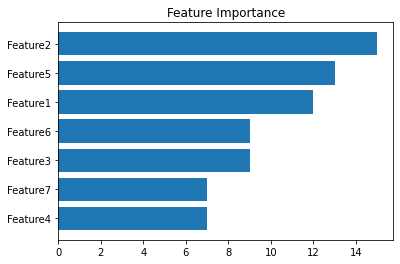

In [14]:
# For Q4

# Use simply counting to get the feature importance: dt_depth10.importance
labelList=['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']
title = 'Feature Importance'
dt_depth10.draw_importance(labelList, title)

# Questions for Random Rorest

In [15]:
# For Q5-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)
rf_estimators10 = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators10.fit(X_train, y_train)

print("Q6-1 n_estimators=10: ", accuracy_score(y_val, rf_estimators10.predict(X_val)))

Q6-1 n_estimators=10:  0.89875


In [16]:
# For Q5-2, validation accuracy should be higher than or equal to 0.89

np.random.seed(0)
rf_estimators50 = RandomForest(n_estimators=50, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_estimators50.fit(X_train, y_train)

print("Q6-1 n_estimators=50: ", accuracy_score(y_val, rf_estimators50.predict(X_val)))

Q6-1 n_estimators=50:  0.9


In [17]:
# For Q6-1, validation accuracy should be higher than or equal to 0.88

np.random.seed(0)
rf_maxfeature_sqrt = RandomForest(n_estimators=10, max_features=np.sqrt(X_train.shape[1]), boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_sqrt.fit(X_train, y_train)

print("Q7-1 max_features='sqrt': ", accuracy_score(y_val,  rf_maxfeature_sqrt.predict(X_val)))

Q7-1 max_features='sqrt':  0.89875


In [18]:
# For Q6-2, validation accuracy should be higher than or equal to 0.86

np.random.seed(0)
rf_maxfeature_none = RandomForest(n_estimators=10, max_features=None, boostrap=True, criterion='gini', max_depth=None)
rf_maxfeature_none.fit(X_train, y_train)

print("Q7-1 max_features='All': ", accuracy_score(y_val, rf_maxfeature_none.predict(X_val)))

Q7-1 max_features='All':  0.875


In [19]:
def normalize(data1, data2, data3):
    npmax = np.max(data1, axis = 0)
    npmin = np.min(data1, axis = 0)
    range_ = npmax - npmin
    return (data1 - npmin)/range_ , (data2 - npmin)/range_ , (data3 - npmin)/range_

def get_feature(data1, data2, data3):
    data_num = np.shape(data1)[0]
    feature_size = np.shape(data1)[1]
    r_data1 = np.zeros((data_num, feature_size + np.int64(feature_size*(feature_size + 1)/2)))
    r_data2 = np.zeros((data_num, feature_size + np.int64(feature_size*(feature_size + 1)/2)))
    r_data3 = np.zeros((data_num, feature_size + np.int64(feature_size*(feature_size + 1)/2)))
    r_data1[:,:feature_size] = data1
    r_data2[:,:feature_size] = data2
    r_data3[:,:feature_size] = data3
    index = feature_size
    r_id = np.array([0,1,2,3,5,6])
    return data1[:,r_id],data2[:,r_id],data3[:,r_id]
           
# Load the train/val/test dataset

df_train = pd.DataFrame(pd.read_csv("./PR_HW3_Train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW3_Val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))

X_train = df_train[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_train = df_train["Target"].to_numpy()

X_val = df_val[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_val = df_val["Target"].to_numpy()

X_test = df_test[['Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'Feature7']].to_numpy()
y_test = df_test["Target"].to_numpy()

X_train_k_fold = np.concatenate((X_train, X_val), axis=0)
y_train_k_fold = np.concatenate((y_train, y_val), axis=0)

# Train your own model

In [20]:
# Build and train your model
class k_fold_forest():
    def __init__(self, k, n_estimators, max_features, boostrap, criterion, max_depth):
        self.k = k
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.forest_list = []
    
    def fit(self, X_train_k_fold, y_train_k_fold):
        average_acc = 0
        for i in range(self.k):
            X_train_ = np.concatenate((X_train_k_fold[0:np.int64(1600*i/self.k)], X_train_k_fold[np.int64(1600*(i+1)/self.k):1600]), axis=0)
            y_train_ = np.concatenate((y_train_k_fold[0:np.int64(1600*i/self.k)], y_train_k_fold[np.int64(1600*(i+1)/self.k):1600]), axis=0)    
            X_val_ = X_train_k_fold[np.int64(1600*i/self.k) : np.int64(1600*(i+1)/self.k)]
            y_val_ = y_train_k_fold[np.int64(1600*i/self.k) : np.int64(1600*(i+1)/self.k)]
            your_model = RandomForest(n_estimators=self.n_estimators, max_features=self.max_features, boostrap=self.boostrap, criterion=self.criterion, max_depth=self.max_depth)
            your_model.fit(X_train_, y_train_)
            print(i," iteration:")
            print("The val of my model : ", accuracy_score(y_val_, your_model.predict(X_val_)))
            average_acc += accuracy_score(y_val_, your_model.predict(X_val_))
            self.forest_list.append(your_model)
        average_acc /= self.k 
        print("average acc: ",average_acc)
    
    def predict(self, X_test_):
        num_data = np.shape(X_test_)[0]
        voting = np.zeros((self.k, num_data))
        prediction = np.zeros((num_data))
        
        for i,forest in enumerate(self.forest_list):
            voting[i] = forest.predict(X_test_)
        
        voting = np.transpose(voting, (1, 0))
        
        for i in range(num_data):
            values, counts = np.unique(voting[i], return_counts=True)
            prediction[i] = values[np.argmax(counts)]       
        
        return prediction
    
np.random.seed(0)
your_model = k_fold_forest(k = 5,n_estimators=450, max_features=2, boostrap=True, criterion='entropy', max_depth=8)
your_model.fit(X_train_k_fold, y_train_k_fold)
val_pred = your_model.predict(X_val)

acc = accuracy_score(y_val, val_pred)
print("total val acc: ", acc)

0  iteration:
The val of my model :  0.8875
1  iteration:
The val of my model :  0.934375
2  iteration:
The val of my model :  0.9
3  iteration:
The val of my model :  0.90625
4  iteration:
The val of my model :  0.90625
average acc:  0.906875
total val acc:  0.96125


In [21]:
test_pred = your_model.predict(X_test)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (800,)


In [22]:
# output csv
df_test = pd.DataFrame(pd.read_csv("./PR_HW3_Test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("0810749_prediction.csv")